In [1]:
import numpy as np
import matplotlib
from scipy.optimize import newton

matplotlib.rcParams['mathtext.default']='regular'
matplotlib.rcParams['xtick.direction']='in'
matplotlib.rcParams['ytick.direction']='in'
matplotlib.rcParams['xtick.top']=True
matplotlib.rcParams['ytick.right']=True
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


from scipy.optimize import newton


from matplotlib import rc
from matplotlib.ticker import ScalarFormatter, AutoMinorLocator, LogLocator


rc('font', family='serif')
rc('text', usetex=True)
params =   {'font.size' : 12,
                'text.usetex' : True,
                'xtick.major.size': 8,
                'ytick.major.size': 8,
                'xtick.minor.size': 3,
                'ytick.minor.size': 3,
                }
plt.rcParams.update(params)


# plt.switch_backend('agg')    #This is required for submitting as a python script 

mu   = 0.6
g    = 5/3
mp   = 1.672622e-24
kb   = 1.380658e-16
pc   = 3.08567758e18       # [cm]      pc 
kpc  = 3.08567758e21       # [cm]      kiloparsec
Msun = 1.98855e33          # [g]       solar mass
yr   = 3.15569e7           # [s]       year
kyr  = yr * 1e3

In [2]:
def CC85(alpha,beta,Rkpc,Msfr):
    # modified from solve ivp notebook, drops the flags and end variables. spherical only.    
    g = 5/3 
    R = Rkpc * kpc
    SFRUnits = Msun/yr
    MdotHotTot = beta*Msfr*SFRUnits
    EdotHotTot = 3.1 * 10**(41) * alpha * Msfr 
 
    
    def f(M,rR):
        if rR < 1 : 
            return ((3*g+1/(M**2))/(1+3*g))**(-(3*g+1)/(5*g+1))*((g-1+2/(M**2))/(1+g))**((g+1)/(2*(5*g+1)))-rR
        else:
            return M**(2/(g-1))*((g-1+2/(M**2))/(1+g))**((g+1)/(2*(g-1)))-rR**2
    vf = np.vectorize(f,otypes=[np.float])
    
    def df(M,rR):
        if rR < 1:
            return (-2)*(M**2-1)*M**(-1)*(2+(g-1)*M**2)**(-1)*(1+3*g*M**2)**(-1)*((3*g+M**(-2))/(1+3*g))**(-(1+3*g)/(1+5*g))*((g-1+2*M**(-2))/(1+g))**((1+g)/(2+10*g))
        else:
            return 2*(2+(g-1)*M**2)**(-1)*(M**2-1)*M**((3-g)/(g-1))*((g-1+2*M**(-2))/(1+g))**((g+1)/(2*(g-1)))
    vdf = np.vectorize(df,otypes=[np.float])  
    
    def guess(rR):                                  
        if rR < 1:
            return rR * 0.1
        else:
            return rR
    vguess = np.vectorize(guess,otypes=[np.float])
    
    def uStar(M):
        return ((2*M**2)/(M**2+2/(g-1)))**(1/2)
    
    def rhoStar(M,rR):
        if rR < 1:
            return  rR / (4 * np.pi * uStar(M)) 
        else:
            return  1 / (4 * np.pi * uStar(M) * rR**2)  
    vrhoStar = np.vectorize(rhoStar,otypes=[np.float])
        
    def PStar(M,rR):
        return vrhoStar(M,rR) * uStar(M)**2 / (g*M**2)
    
    def u(M):
        return uStar(M) * (EdotHotTot/MdotHotTot)**(1/2) # cm/s 

    def rho(M,sS):
        return vrhoStar(M,sS) * (MdotHotTot)**(3/2) * (EdotHotTot)**(-1/2) * R**(-2) # g/cm^3 

    def P(M,sS): 
        return PStar(M,sS) * (MdotHotTot)**(1/2) * (EdotHotTot)**(1/2) * R**(-2)  # g/(cm s^2) 
        


    rStar_vals = np.logspace(-2,2,num=1000)
    x0 = vguess(rStar_vals)
    M_vals = newton(vf, x0, fprime=vdf, args=(rStar_vals, ))

    uStar_vals = uStar(M_vals)
    rhoStar_vals = vrhoStar(M_vals,rStar_vals)
    PStar_vals = PStar(M_vals,rStar_vals)
    
    u_vals = u(M_vals)
    rho_vals = rho(M_vals,rStar_vals)
    P_vals = P(M_vals,rStar_vals)
    
    return rStar_vals, M_vals, uStar_vals, rhoStar_vals, PStar_vals, u_vals, rho_vals, P_vals

In [21]:
alpha, beta, Rkpc, Msfr = 1, 0.3, 0.3, 10
rStar_a, M_a, uStar_a, rhoStar_a, PStar_a, u_a, rho_a, P_a = CC85(alpha,beta,Rkpc,Msfr)

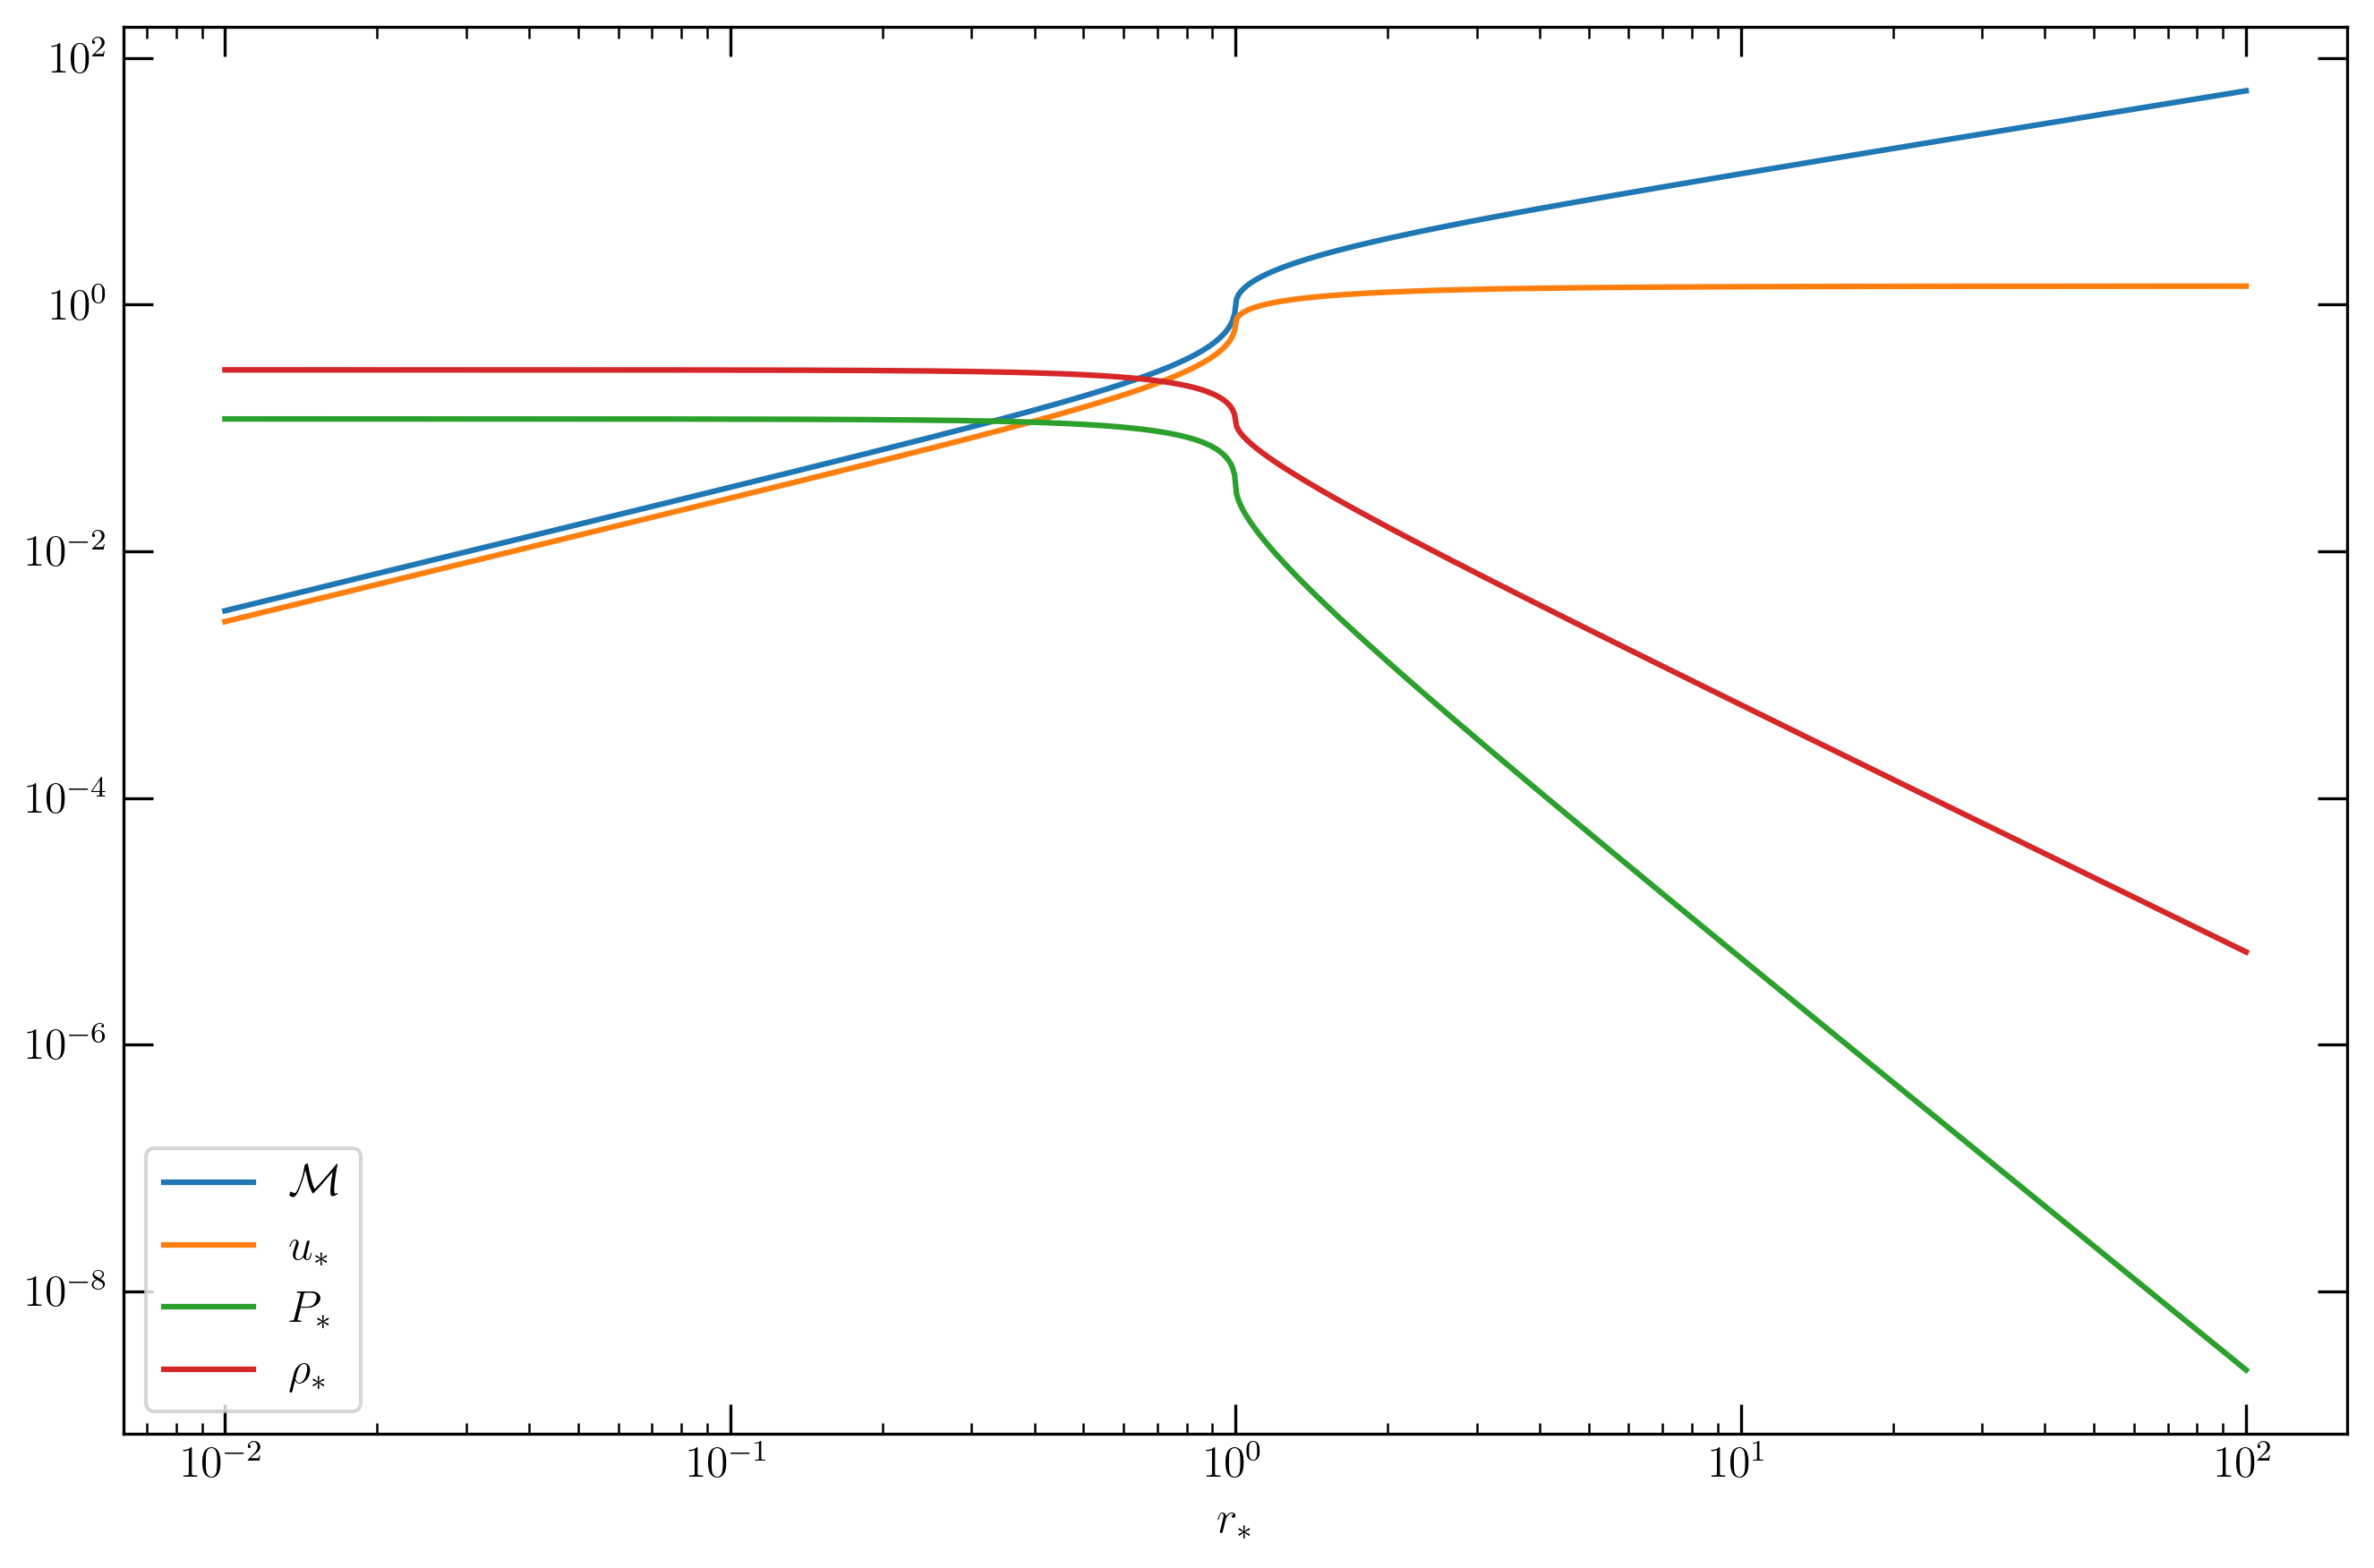

In [22]:
fig = plt.figure(figsize=(9,6),dpi=300)
ax1 = fig.add_subplot(1,1,1)

ax1.plot(rStar_a,M_a,label='$\mathcal{M}$')
ax1.plot(rStar_a,uStar_a,label='$u_*$')
ax1.plot(rStar_a,PStar_a,label='$P_*$')
ax1.plot(rStar_a,rhoStar_a,label='$\\rho_*$')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend(loc=3)
ax1.set_xlabel('$r_*$')

fig.tight_layout()
#plt.savefig('CC85_dimensionless_solutions.png',facecolor='white')

In [23]:
R = Rkpc * kpc
r_a = rStar_a * R        # r is in units of cm 
n_a = rho_a / (mu*mp)

# Ideal gas law : P = n k T      so T = P / (nk) 
T_a = P_a / (kb * n_a) 

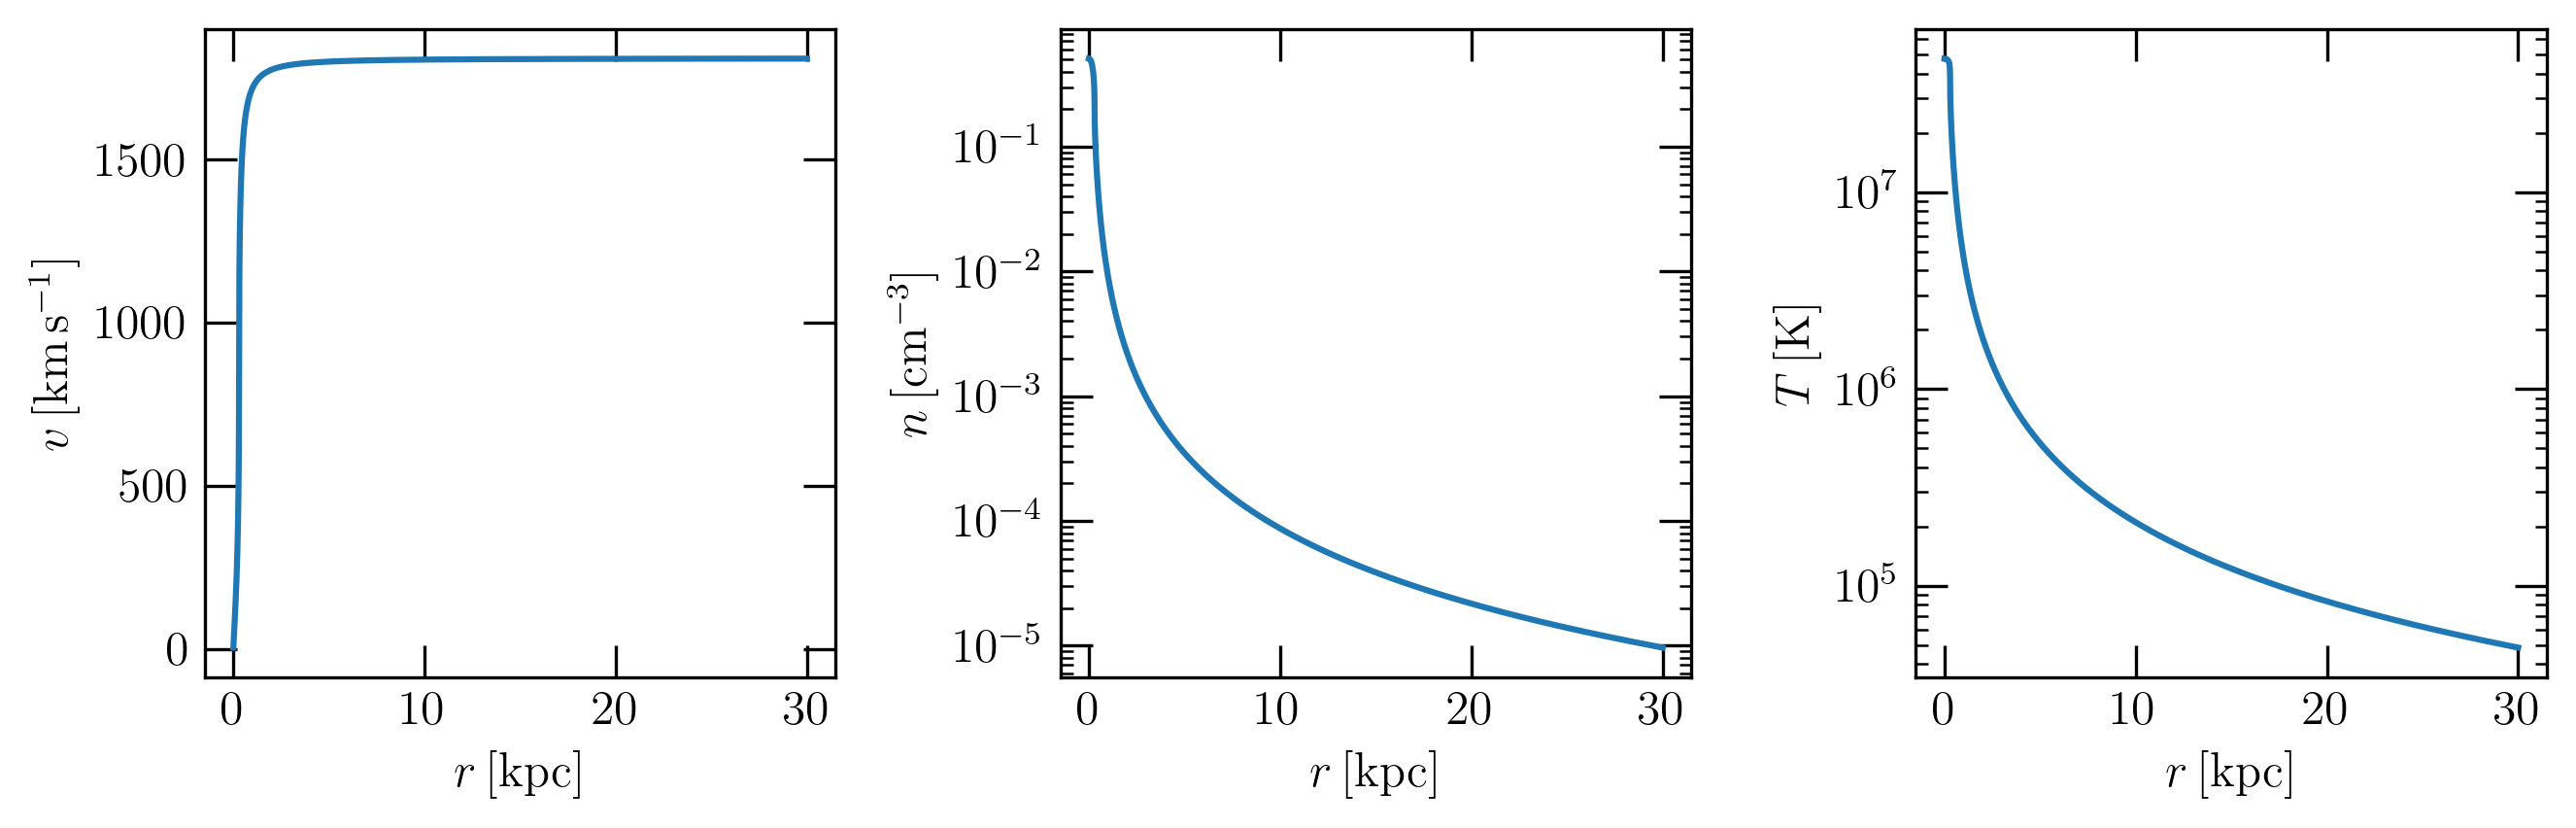

In [24]:
fig = plt.figure(figsize=(9,3),dpi=300)
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)


ax1.plot(r_a/kpc,u_a/1e5)
ax1.set_xlabel('$r\,\mathrm{[kpc]}$')
ax1.set_ylabel('$v\,\mathrm{[km\,s^{-1}]}$')

ax2.plot(r_a/kpc,n_a)
ax2.set_yscale('log')
ax2.set_xlabel('$r\,\mathrm{[kpc]}$')
ax2.set_ylabel('$n\,\mathrm{[cm^{-3}]}$')

ax3.plot(r_a/kpc,T_a)
ax3.set_yscale('log')
ax3.set_xlabel('$r\,\mathrm{[kpc]}$')
ax3.set_ylabel('$T\,\mathrm{[K]}$')

fig.tight_layout()
#plt.savefig('CC85_dimensionless_solutions.png',facecolor='white')

In [26]:
alpha, beta, Msfr, Rkpc = 1, 0.3, 10, 0.3 

alpha_a = 0.1 
alpha_b = 0.5
alpha_c = 1.0 



rStar_a, M_a, uStar_a, rhoStar_a, PStar_a, u_a, rho_a, P_a = CC85(alpha_a,beta,Rkpc,Msfr)

rStar_b, M_b, uStar_b, rhoStar_b, PStar_b, u_b, rho_b, P_b = CC85(alpha_b,beta,Rkpc,Msfr)

rStar_c, M_c, uStar_c, rhoStar_c, PStar_c, u_c, rho_c, P_c = CC85(alpha_c,beta,Rkpc,Msfr)


r_a, r_b, r_c = rStar_a * Rkpc, rStar_b * Rkpc, rStar_c * Rkpc       # r is now in units of kpc 
n_a, n_b, n_c = rho_a / (mu*mp),  rho_b / (mu*mp),  rho_c / (mu*mp)
T_a, T_b, T_c = P_a / (kb * n_a), P_b / (kb * n_b) , P_c / (kb * n_c) 

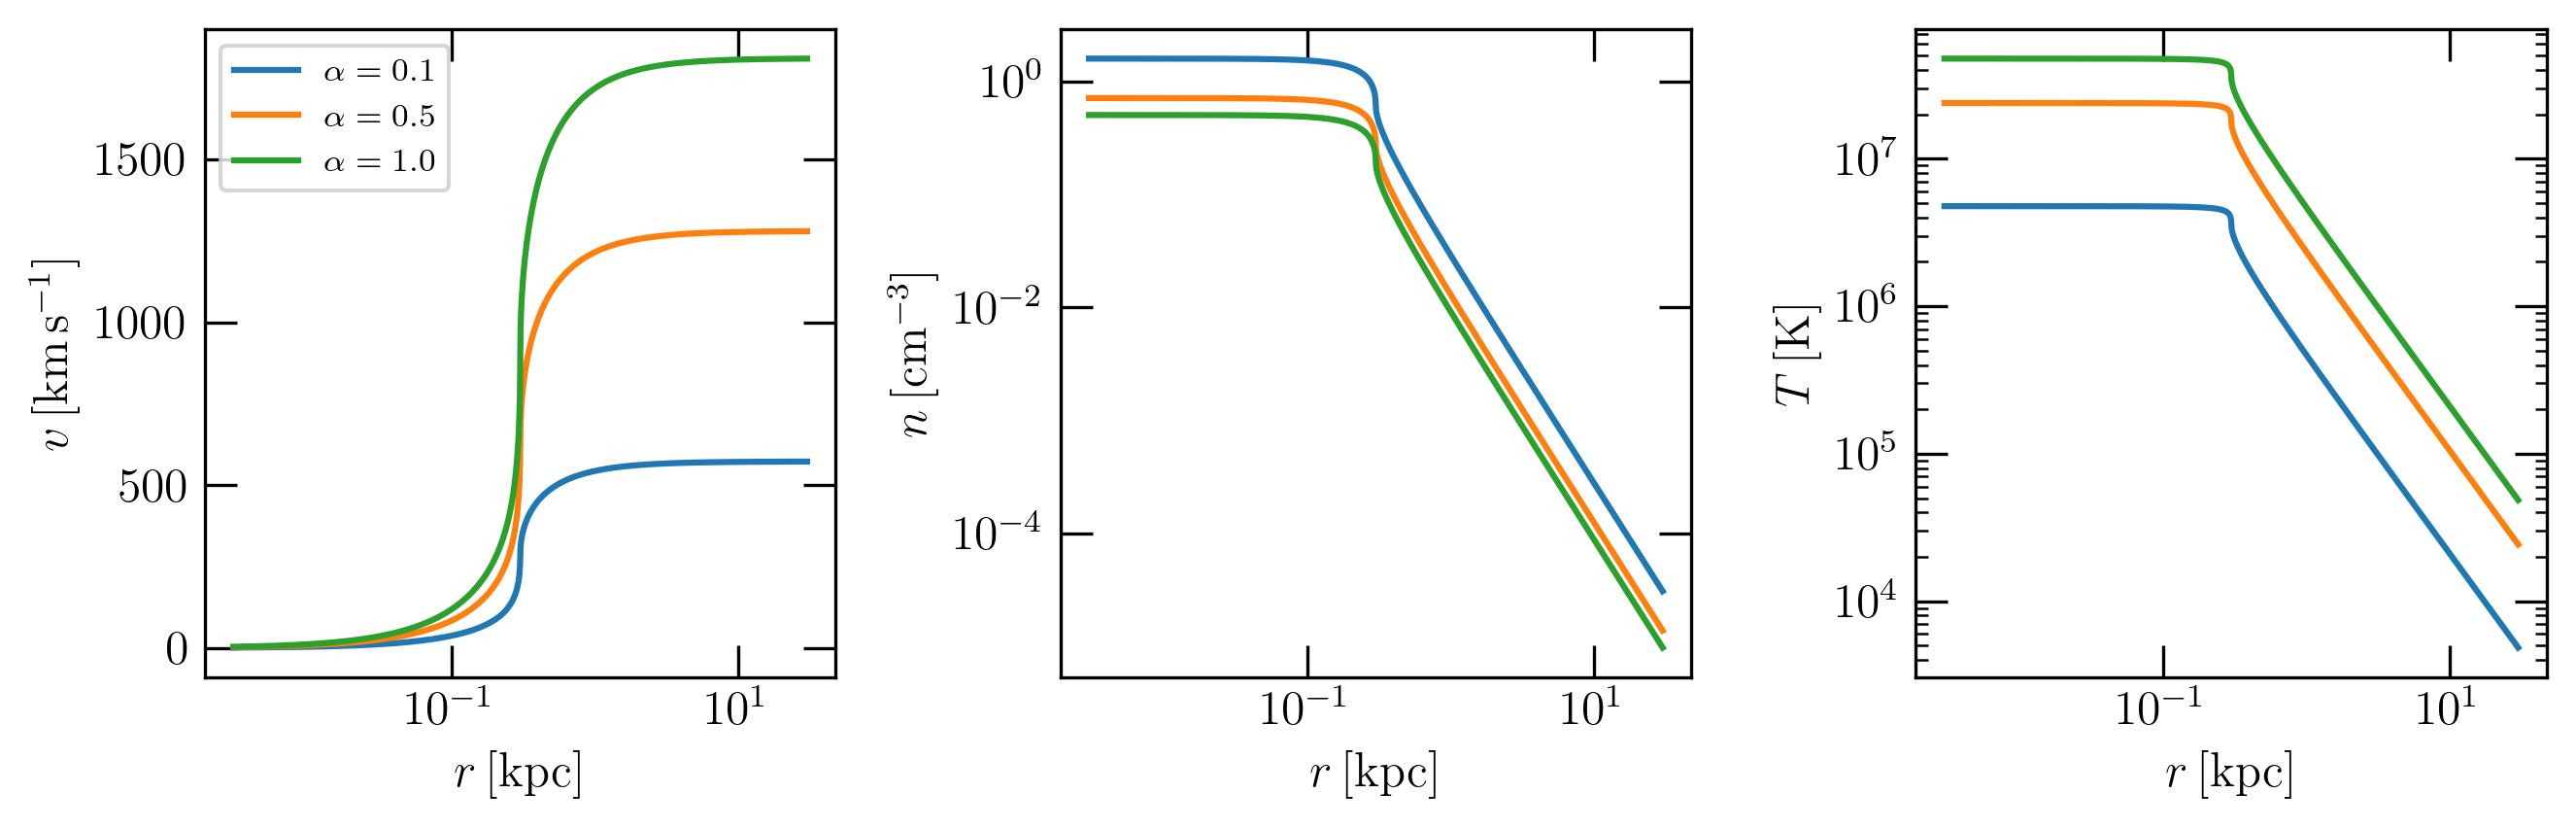

In [29]:
fig = plt.figure(figsize=(9,3),dpi=300)
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)


ax1.plot(r_a,u_a/1e5,label='$\\alpha=0.1$')
ax1.plot(r_b,u_b/1e5,label='$\\alpha=0.5$')
ax1.plot(r_c,u_c/1e5,label='$\\alpha=1.0$')
ax1.set_xlabel('$r\,\mathrm{[kpc]}$')
ax1.set_ylabel('$v\,\mathrm{[km\,s^{-1}]}$')
ax1.set_xscale('log')
ax1.legend(loc=0,prop={'size': 8})

ax2.plot(r_a,n_a)
ax2.plot(r_b,n_b)
ax2.plot(r_c,n_c)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('$r\,\mathrm{[kpc]}$')
ax2.set_ylabel('$n\,\mathrm{[cm^{-3}]}$')

ax3.plot(r_a,T_a)
ax3.plot(r_b,T_b)
ax3.plot(r_c,T_c)
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_xlabel('$r\,\mathrm{[kpc]}$')
ax3.set_ylabel('$T\,\mathrm{[K]}$')

fig.tight_layout()
#plt.savefig('CC85_dimensionless_solutions.png',facecolor='white')